In [4]:
# ============================================================
# Lesion Rollouts Interactive Plotter (self-contained)
# - Point ROOT_DIR at: /Users/adi/Desktop/Lesion_rollouts_temp
# - Works directly on the cleaned *_rollout_log.csv files (no header).
# - Lets you filter by: src cycle, src behavior, dst behavior, condition, run-id, seed
# - Plots faint individual runs + bold mean (optional ±1σ band)
# - Manual/auto x-range crop
# ============================================================

from __future__ import annotations

import re
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid")

# ----------------------------
# CONFIG
# ----------------------------
ROOT_DIR = Path("/Users/adi/Desktop/Lesion_rollouts_temp").expanduser().resolve()

# If your rollout logs are huge, you can limit read size (None = full file)
MAX_ROWS_PER_CSV = None  # e.g. 200000

# ----------------------------
# Filename parser
# ----------------------------
# Your filenames look like:
# Adapt_Baseline0__run00__c003_jump__original__jump_to_walk__seed289555729__rollout_log.csv
FNAME_RE = re.compile(
    r"""
    ^(?P<prefix>.+?)__                 # Adapt_Baseline0
    run(?P<runid>\d+)__                # run00
    (?P<src_cycle>c\d+)_(?P<src_behavior>walk|jump|spin)__
    (?P<condition>original|selflesion|tasklesion)__
    (?P<transition>(?P<src2>walk|jump|spin)_to_(?P<dst_behavior>walk|jump|spin))__
    seed(?P<seed>\d+)__
    rollout_log\.csv$
    """,
    re.VERBOSE | re.IGNORECASE,
)

def parse_rollout_filename(p: Path) -> dict | None:
    m = FNAME_RE.match(p.name)
    if not m:
        return None
    d = m.groupdict()
    # normalize
    d["runid"] = f"run{int(d['runid']):02d}"
    d["condition"] = d["condition"].lower()
    d["src_cycle"] = d["src_cycle"].lower()
    d["src_behavior"] = d["src_behavior"].lower()
    d["dst_behavior"] = d["dst_behavior"].lower()
    d["transition_label"] = f"{d['src_behavior']}→{d['dst_behavior']}"
    d["seed"] = int(d["seed"])
    d["path"] = str(p.resolve())
    return d

# ----------------------------
# CSV reader (your log has no header)
# We use:
#   steps  = col 1 (index 1)  OR col 2 (index 2) depending on format
#   return = col 3 (index 3)
# From your earlier snippet:
#   time, steps?, frames?, return, ...
# In your earlier code you used: steps=col2 (index 2), return=col3 (index 3).
# We'll autodetect between col1 and col2 for steps by monotonicity.
# ----------------------------
_rollout_cache: dict[str, pd.DataFrame] = {}

def read_rollout_csv(path: str) -> pd.DataFrame:
    arr = pd.read_csv(path, header=None, nrows=MAX_ROWS_PER_CSV)

    # candidate columns
    # steps candidates: col1 or col2 (0-based 1 or 2)
    c_steps1 = pd.to_numeric(arr.iloc[:, 1], errors="coerce")
    c_steps2 = pd.to_numeric(arr.iloc[:, 2], errors="coerce")
    c_ret    = pd.to_numeric(arr.iloc[:, 3], errors="coerce")

    # pick steps column that looks more like increasing steps:
    def score_steps(s: pd.Series) -> float:
        s = s.dropna()
        if len(s) < 10:
            return -1e9
        ds = np.diff(s.to_numpy(dtype=float))
        # score: more nonnegative diffs and larger max
        return float((ds >= 0).mean()) * 1e6 + float(np.nanmax(s))

    use_steps = c_steps2 if score_steps(c_steps2) >= score_steps(c_steps1) else c_steps1

    df = pd.DataFrame({"steps": use_steps, "return": c_ret}).dropna()
    df = df.sort_values("steps")
    df = df.drop_duplicates(subset=["steps"], keep="last")
    return df.reset_index(drop=True)

def get_rollout(path: str) -> pd.DataFrame:
    if path not in _rollout_cache:
        _rollout_cache[path] = read_rollout_csv(path)
    return _rollout_cache[path]

# ----------------------------
# Group interpolation + smoothing
# ----------------------------
def interpolate_group(runs: list[pd.DataFrame], n_grid: int = 400):
    if not runs:
        return None, None

    mins = [float(r["steps"].min()) for r in runs if len(r)]
    maxs = [float(r["steps"].max()) for r in runs if len(r)]
    if not mins or not maxs:
        return None, None

    x_min = min(mins)
    x_max = max(maxs)
    if x_max <= x_min:
        return None, None

    xgrid = np.linspace(x_min, x_max, int(n_grid))
    Y = np.full((len(runs), len(xgrid)), np.nan, dtype=float)

    for i, r in enumerate(runs):
        x = r["steps"].to_numpy(dtype=float)
        y = r["return"].to_numpy(dtype=float)
        if len(x) < 2:
            continue
        y_interp = np.interp(xgrid, x, y)
        mask = (xgrid < x.min()) | (xgrid > x.max())
        y_interp = y_interp.astype(float)
        y_interp[mask] = np.nan
        Y[i, :] = y_interp

    return xgrid, Y

def smooth_mean(y: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return y
    s = pd.Series(y)
    return s.rolling(window=window, min_periods=max(3, window // 3), center=True).mean().to_numpy()

# ----------------------------
# Build metadata from directory
# ----------------------------
if not ROOT_DIR.exists():
    raise FileNotFoundError(f"ROOT_DIR does not exist: {ROOT_DIR}")

csv_files = sorted(ROOT_DIR.glob("*.csv"))
meta_rows = []
bad = 0
for p in csv_files:
    d = parse_rollout_filename(p)
    if d is None:
        bad += 1
        continue
    meta_rows.append(d)

if not meta_rows:
    raise RuntimeError(
        f"No matching rollout CSVs found in {ROOT_DIR}\n"
        f"Expected names like: Adapt_Baseline0__run00__c003_jump__original__jump_to_walk__seed123__rollout_log.csv\n"
        f"Found {len(csv_files)} CSVs, {bad} did not match parser."
    )

meta = pd.DataFrame(meta_rows)

# Options
transition_options = sorted(meta["transition_label"].unique().tolist())
condition_options  = sorted(meta["condition"].unique().tolist())
cycle_options      = sorted(meta["src_cycle"].unique().tolist())
srcb_options       = sorted(meta["src_behavior"].unique().tolist())
dstb_options       = sorted(meta["dst_behavior"].unique().tolist())
runid_options      = sorted(meta["runid"].unique().tolist())

# Precompute global x range (quick scan by reading min/max per file)
global_min = None
global_max = None
for p in meta["path"].tolist():
    df = get_rollout(p)
    if df.empty:
        continue
    mn = float(df["steps"].min())
    mx = float(df["steps"].max())
    global_min = mn if global_min is None else min(global_min, mn)
    global_max = mx if global_max is None else max(global_max, mx)
global_min = 0.0 if global_min is None else global_min
global_max = 1.0 if global_max is None else global_max

# ----------------------------
# Widgets
# ----------------------------
w_transitions = widgets.SelectMultiple(
    options=transition_options,
    value=tuple(transition_options[:1]) if transition_options else tuple(),
    description="Transition",
    layout=widgets.Layout(width="320px", height="180px"),
)

w_conditions = widgets.SelectMultiple(
    options=condition_options,
    value=tuple(condition_options),
    description="Condition",
    layout=widgets.Layout(width="260px", height="180px"),
)

w_cycles = widgets.SelectMultiple(
    options=cycle_options,
    value=tuple(cycle_options),
    description="Cycle",
    layout=widgets.Layout(width="220px", height="180px"),
)

w_runids = widgets.SelectMultiple(
    options=runid_options,
    value=tuple(runid_options),
    description="Run",
    layout=widgets.Layout(width="200px", height="180px"),
)

w_srcb = widgets.SelectMultiple(
    options=srcb_options,
    value=tuple(srcb_options),
    description="Src beh",
    layout=widgets.Layout(width="220px", height="140px"),
)

w_dstb = widgets.SelectMultiple(
    options=dstb_options,
    value=tuple(dstb_options),
    description="Dst beh",
    layout=widgets.Layout(width="220px", height="140px"),
)

w_seed_substr = widgets.Text(
    value="",
    description="Seed filter",
    placeholder="e.g. 466 or leave blank",
    layout=widgets.Layout(width="420px"),
)

w_n_grid = widgets.IntSlider(
    value=450, min=150, max=1600, step=50,
    description="Grid pts", continuous_update=False
)

w_smooth = widgets.IntSlider(
    value=25, min=1, max=201, step=2,
    description="Smooth", continuous_update=False
)

w_alpha = widgets.FloatSlider(
    value=0.18, min=0.02, max=0.75, step=0.02,
    description="Faint α", continuous_update=False
)

w_mean_lw = widgets.FloatSlider(
    value=3.8, min=1.5, max=8.0, step=0.1,
    description="Mean lw", continuous_update=False
)

w_show_band = widgets.Checkbox(value=False, description="±1σ band")
w_show_raw  = widgets.Checkbox(value=True,  description="Faint runs")
w_legend_out = widgets.Checkbox(value=True, description="Legend outside")

# x-range controls
w_x_auto = widgets.Checkbox(value=True, description="Auto x-range")
w_x_min = widgets.FloatSlider(
    value=float(global_min), min=float(global_min), max=float(global_max),
    step=max(1.0, (global_max-global_min)/200.0),
    description="x min", continuous_update=False, readout_format=".0f",
    layout=widgets.Layout(width="420px"),
)
w_x_max = widgets.FloatSlider(
    value=float(global_max), min=float(global_min), max=float(global_max),
    step=max(1.0, (global_max-global_min)/200.0),
    description="x max", continuous_update=False, readout_format=".0f",
    layout=widgets.Layout(width="420px"),
)

w_title = widgets.Text(
    value="Lesion Rollouts: Return vs Steps",
    description="Title",
    layout=widgets.Layout(width="860px"),
)

def _sync_x_enabled(*_):
    disabled = bool(w_x_auto.value)
    w_x_min.disabled = disabled
    w_x_max.disabled = disabled

w_x_auto.observe(_sync_x_enabled, names="value")
_sync_x_enabled()

# consistent colors per (transition, condition)
pairs_all = sorted(set(zip(meta["transition_label"].astype(str), meta["condition"].astype(str))))
palette = sns.color_palette(n_colors=max(3, len(pairs_all)))
pair_color = {pair: palette[i % len(palette)] for i, pair in enumerate(pairs_all)}

ui = widgets.VBox([
    w_title,
    widgets.HBox([w_transitions, w_conditions, w_cycles, w_runids]),
    widgets.HBox([w_srcb, w_dstb]),
    widgets.HBox([w_seed_substr, w_n_grid, w_smooth]),
    widgets.HBox([w_x_auto, w_x_min, w_x_max]),
    widgets.HBox([w_show_raw, w_show_band, w_legend_out, w_alpha, w_mean_lw]),
])

out = widgets.Output()

# ----------------------------
# Plot update
# ----------------------------
def update_plot(*_):
    with out:
        clear_output(wait=True)

        sel_trans = list(w_transitions.value)
        sel_cond  = list(w_conditions.value)
        sel_cyc   = list(w_cycles.value)
        sel_run   = list(w_runids.value)
        sel_srcb  = list(w_srcb.value)
        sel_dstb  = list(w_dstb.value)
        seed_filt = w_seed_substr.value.strip()

        if not sel_trans or not sel_cond:
            print("Select at least one transition and one condition.")
            return

        df = meta[
            meta["transition_label"].astype(str).isin(sel_trans) &
            meta["condition"].astype(str).isin(sel_cond) &
            meta["src_cycle"].astype(str).isin(sel_cyc) &
            meta["runid"].astype(str).isin(sel_run) &
            meta["src_behavior"].astype(str).isin(sel_srcb) &
            meta["dst_behavior"].astype(str).isin(sel_dstb)
        ].copy()

        if seed_filt:
            # substring match on seed
            df = df[df["seed"].astype(str).str.contains(seed_filt, na=False)]

        if df.empty:
            print("No runs match current filters.")
            print("Transitions:", sel_trans)
            print("Conditions:", sel_cond)
            print("Cycles:", sel_cyc)
            print("Runs:", sel_run)
            print("Src beh:", sel_srcb)
            print("Dst beh:", sel_dstb)
            print("Seed filter:", seed_filt if seed_filt else "(none)")
            return

        # manual x-range
        x_min_user = float(w_x_min.value)
        x_max_user = float(w_x_max.value)
        if (not w_x_auto.value) and (x_max_user <= x_min_user):
            print("Bad x-range: x max must be > x min")
            return

        groups = df.groupby(["transition_label", "condition"], sort=True)

        fig, ax = plt.subplots(figsize=(12, 7))
        sns.despine(ax=ax)

        ax.set_title(w_title.value)
        ax.set_xlabel("steps")
        ax.set_ylabel("return")

        legend_handles, legend_labels = [], []
        summary_rows = []

        for (trans, cond), g in groups:
            paths = g["path"].tolist()
            runs_all = [get_rollout(p) for p in paths]

            # apply x-range crop if manual
            if w_x_auto.value:
                runs = runs_all
            else:
                runs = []
                for r in runs_all:
                    rr = r[(r["steps"] >= x_min_user) & (r["steps"] <= x_max_user)].copy()
                    if len(rr) >= 2:
                        runs.append(rr)

            if not runs:
                continue

            color = pair_color[(str(trans), str(cond))]
            label = f"{trans} | {cond} (n={len(runs)})"

            # faint runs
            if w_show_raw.value:
                for r in runs:
                    ax.plot(r["steps"], r["return"], color=color, alpha=float(w_alpha.value), linewidth=1.0)

            # mean via interpolation
            xgrid, Y = interpolate_group(runs, n_grid=int(w_n_grid.value))
            if xgrid is None:
                continue

            mean = np.nanmean(Y, axis=0)
            std  = np.nanstd(Y, axis=0)
            mean_s = smooth_mean(mean, int(w_smooth.value))

            ax.plot(xgrid, mean_s, color=color, linewidth=float(w_mean_lw.value), alpha=1.0)

            if w_show_band.value:
                ax.fill_between(xgrid, mean_s - std, mean_s + std, color=color, alpha=0.12, linewidth=0)

            legend_handles.append(Line2D([0], [0], color=color, lw=5.5, alpha=1.0))
            legend_labels.append(label)

            summary_rows.append({
                "transition": trans,
                "condition": cond,
                "n_runs": len(runs),
                "cycles": ", ".join(sorted(set(g["src_cycle"].astype(str)))),
                "max_steps_used": float(np.nanmax(xgrid[np.isfinite(mean)])) if np.isfinite(mean).any() else np.nan,
            })

        if not legend_labels:
            print("Nothing to plot after applying filters (and x-range crop).")
            return

        if not w_x_auto.value:
            ax.set_xlim(x_min_user, x_max_user)

        ax.grid(True, alpha=0.25)

        if w_legend_out.value:
            ax.legend(
                handles=legend_handles,
                labels=legend_labels,
                loc="upper left",
                bbox_to_anchor=(1.02, 1.0),
                frameon=True,
                framealpha=0.95,
                fontsize=12,
                title="transition | condition",
                title_fontsize=12,
            )
            plt.tight_layout()
        else:
            ax.legend(
                handles=legend_handles,
                labels=legend_labels,
                loc="best",
                frameon=True,
                framealpha=0.95,
                fontsize=12,
            )

        plt.show()

        summ = pd.DataFrame(summary_rows).sort_values(["transition", "condition"])
        display(summ)

# wire callbacks
for w in [
    w_transitions, w_conditions, w_cycles, w_runids,
    w_srcb, w_dstb, w_seed_substr,
    w_n_grid, w_smooth, w_alpha, w_mean_lw,
    w_x_auto, w_x_min, w_x_max,
    w_show_band, w_show_raw, w_legend_out, w_title
]:
    w.observe(update_plot, names="value")

display(ui, out)
update_plot()


Output()

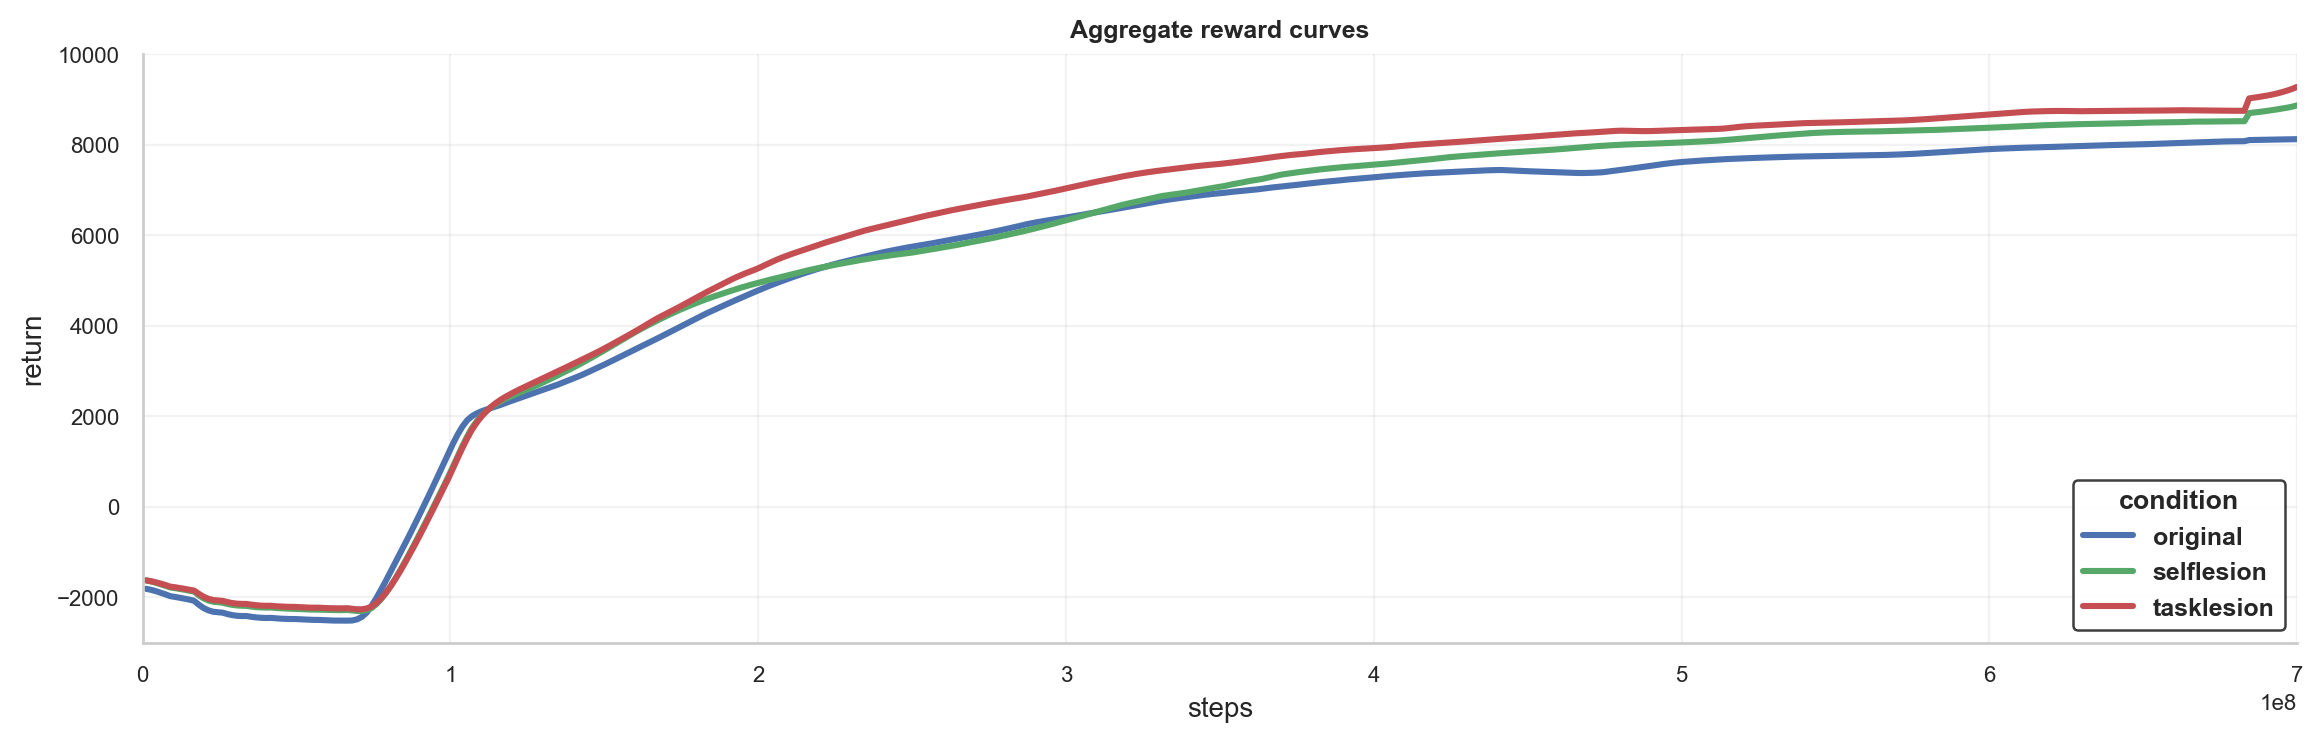

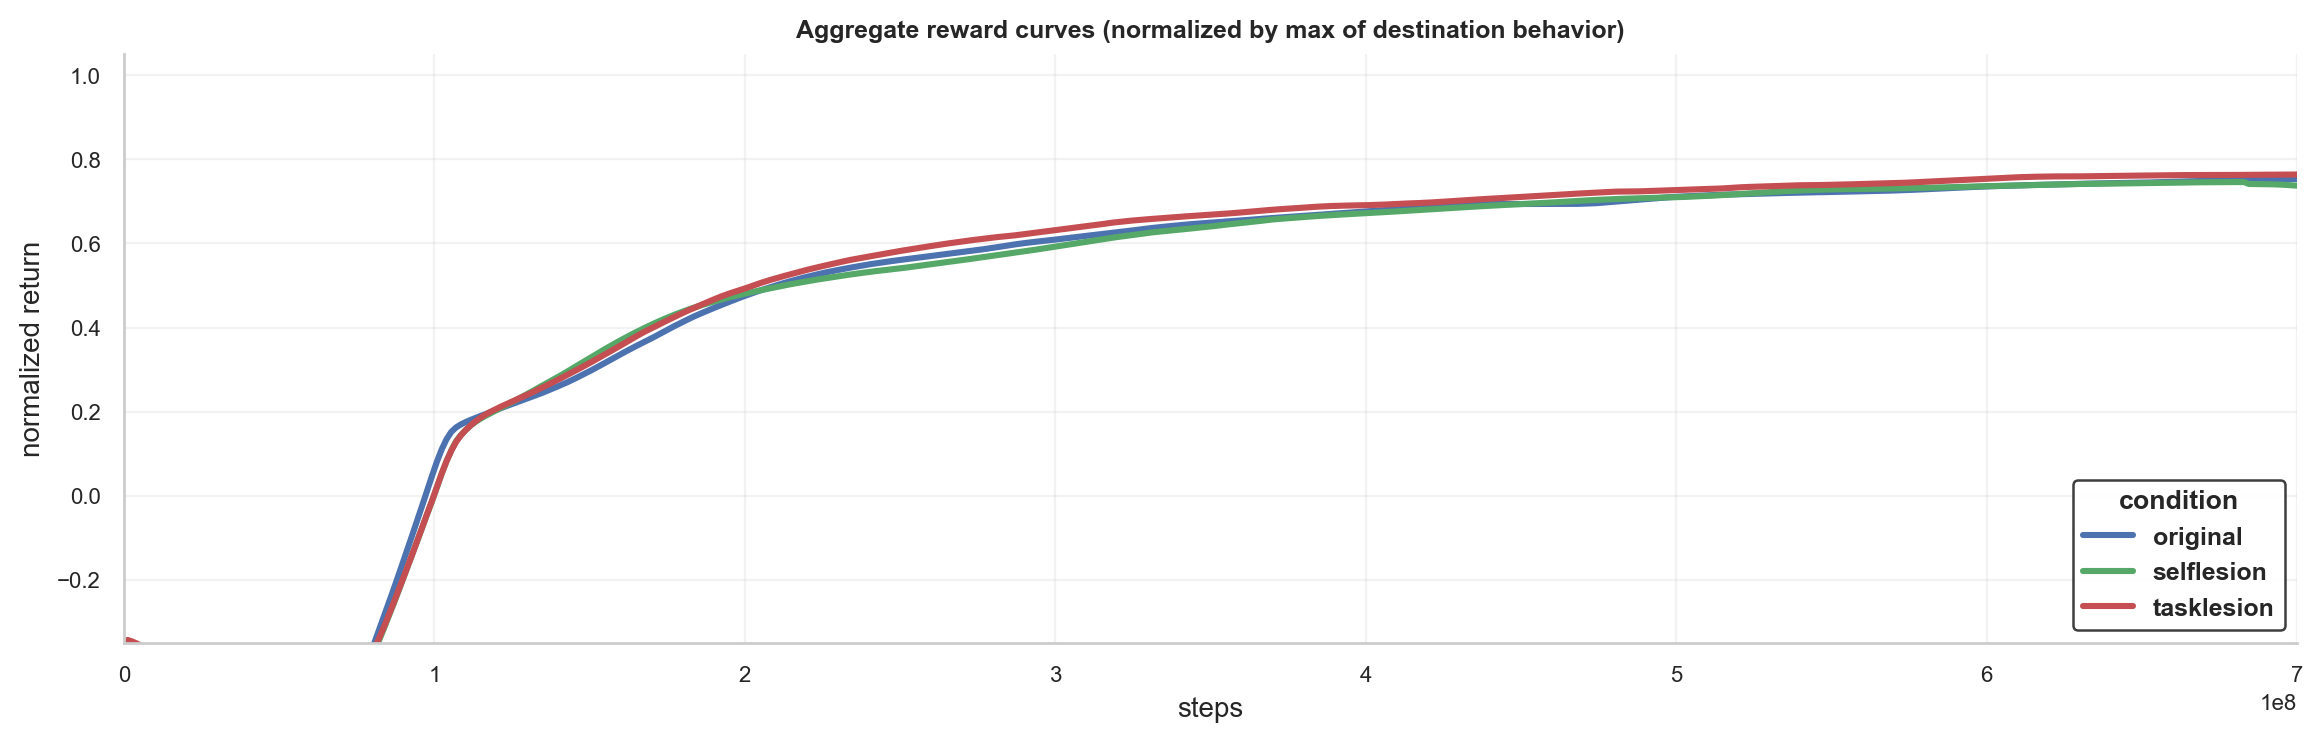

In [3]:
# ============================================================
# TWO FIGURES (paper-ready):
#   (1) FLAT / WIDE aggregate reward curves (same as before, but wider aspect)
#   (2) NORMALIZED aggregate curves:
#       - normalize each run by max reward of its DEST behavior (walk/spin/jump)
#       - then pool all runs and plot one curve per condition on [~0, 1]
#
# Notes:
# - SUCCESS = CSV has >= 20 rows
# - x cropped to 7e8
# - condition colors consistent
# - legends boxed + bold, bottom-right inside plot
# ============================================================

from __future__ import annotations

import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
ROOT_DIR = Path("/Users/adi/Desktop/Lesion_rollouts_temp").expanduser().resolve()
MIN_ROWS_SUCCESS = 20
X_MAX = 7e8

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 9,
})

COND_ORDER = ["original", "selflesion", "tasklesion"]
deep = sns.color_palette("deep")
COND_COLOR = {
    "original":  deep[0],
    "selflesion": deep[2],
    "tasklesion": deep[3],
}

SMOOTH_WINDOW = 21
GRID_PTS = 450
MEAN_LW = 2.2

# ----------------------------
# Helpers
# ----------------------------
def count_rows_fast(p: Path) -> int:
    with p.open("r", errors="replace") as f:
        return sum(1 for _ in f)

def parse_from_parts(fname: str):
    """
    Parses:
      ...__original__jump_to_spin__... .csv
    Returns: condition, src_behavior, dst_behavior
    """
    name = fname[:-4] if fname.endswith(".csv") else fname
    parts = name.split("__")

    condition = None
    for part in parts:
        pl = part.lower()
        if pl in ("original", "selflesion", "tasklesion"):
            condition = pl
            break

    src_b = dst_b = None
    for part in parts:
        m = re.match(r"^(walk|jump|spin)_to_(walk|jump|spin)$", part.lower())
        if m:
            src_b, dst_b = m.group(1), m.group(2)
            break

    if condition is None or src_b is None or dst_b is None:
        return None
    return {"condition": condition, "src": src_b, "dst": dst_b}

_rollout_cache: dict[str, pd.DataFrame] = {}

def read_rollout_csv(path: str) -> pd.DataFrame:
    arr = pd.read_csv(path, header=None)

    c_steps1 = pd.to_numeric(arr.iloc[:, 1], errors="coerce")
    c_steps2 = pd.to_numeric(arr.iloc[:, 2], errors="coerce")
    c_ret    = pd.to_numeric(arr.iloc[:, 3], errors="coerce")

    def score_steps(s: pd.Series) -> float:
        s = s.dropna()
        if len(s) < 10:
            return -1e9
        ds = np.diff(s.to_numpy(dtype=float))
        return float((ds >= 0).mean()) * 1e6 + float(np.nanmax(s))

    steps = c_steps2 if score_steps(c_steps2) >= score_steps(c_steps1) else c_steps1

    df = pd.DataFrame({"steps": steps, "return": c_ret}).dropna()
    df = df.sort_values("steps")
    df = df.drop_duplicates(subset=["steps"], keep="last")
    return df.reset_index(drop=True)

def get_rollout(path: str) -> pd.DataFrame:
    if path not in _rollout_cache:
        _rollout_cache[path] = read_rollout_csv(path)
    return _rollout_cache[path]

def crop_run(df: pd.DataFrame, x_max: float) -> pd.DataFrame:
    if df.empty:
        return df
    out = df[df["steps"] <= x_max].copy()
    return out if len(out) >= 2 else pd.DataFrame(columns=df.columns)

def interpolate_group(runs: list[pd.DataFrame], n_grid: int):
    if not runs:
        return None, None

    mins = [float(r["steps"].min()) for r in runs if len(r)]
    maxs = [float(r["steps"].max()) for r in runs if len(r)]
    if not mins or not maxs:
        return None, None

    x_min = min(mins)
    x_max = max(maxs)
    if x_max <= x_min:
        return None, None

    xgrid = np.linspace(x_min, x_max, int(n_grid))
    Y = np.full((len(runs), len(xgrid)), np.nan, dtype=float)

    for i, r in enumerate(runs):
        x = r["steps"].to_numpy(dtype=float)
        y = r["return"].to_numpy(dtype=float)
        if len(x) < 2:
            continue
        yi = np.interp(xgrid, x, y)
        yi[(xgrid < x.min()) | (xgrid > x.max())] = np.nan
        Y[i, :] = yi

    return xgrid, Y

def smooth_centered(y: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return y
    return pd.Series(y).rolling(window=window, center=True, min_periods=max(3, window//3)).mean().to_numpy()

def style_legend(leg):
    if leg is None:
        return
    title = leg.get_title()
    if title is not None:
        title.set_fontweight("bold")
    for t in leg.get_texts():
        t.set_fontweight("bold")
    frame = leg.get_frame()
    frame.set_linewidth(0.9)
    frame.set_edgecolor("0.2")
    frame.set_alpha(0.95)
    frame.set_facecolor("white")

# ----------------------------
# Index successful runs
# ----------------------------
csvs = sorted(ROOT_DIR.glob("*.csv"))
rows = []
for p in csvs:
    meta = parse_from_parts(p.name)
    if meta is None:
        continue
    if count_rows_fast(p) < MIN_ROWS_SUCCESS:
        continue
    rows.append({
        "path": str(p.resolve()),
        "condition": meta["condition"],
        "src": meta["src"],
        "dst": meta["dst"],
    })

df_meta = pd.DataFrame(rows)
if df_meta.empty:
    raise RuntimeError(f"No successful (>= {MIN_ROWS_SUCCESS} rows) rollout CSVs parsed in: {ROOT_DIR}")

# ----------------------------
# (1) FLAT / WIDE aggregate plot (raw return)
# ----------------------------
fig1, ax1 = plt.subplots(figsize=(11.5, 3.6), constrained_layout=True)  # <<< wider + shorter
sns.despine(ax=ax1)

ax1.set_title("Aggregate reward curves", fontweight="bold")
ax1.set_xlabel("steps")
ax1.set_ylabel("return")

for cond in COND_ORDER:
    sub = df_meta[df_meta["condition"] == cond]
    if sub.empty:
        continue

    runs = []
    for pth in sub["path"].tolist():
        rr = crop_run(get_rollout(pth), X_MAX)
        if len(rr) >= 2:
            runs.append(rr)
    if not runs:
        continue

    xgrid, Y = interpolate_group(runs, n_grid=GRID_PTS)
    if xgrid is None:
        continue

    mean = smooth_centered(np.nanmean(Y, axis=0), SMOOTH_WINDOW)

    ax1.plot(xgrid, mean, color=COND_COLOR[cond], lw=MEAN_LW, solid_capstyle="round", label=cond)

ax1.grid(True, alpha=0.25)
ax1.set_xlim(0, X_MAX)
ax1.set_ylim(-3000, 10000)  # as you set before

leg1 = ax1.legend(title="condition", frameon=True, loc="lower right")
style_legend(leg1)

plt.show()

# ----------------------------
# Compute per-destination behavior max reward (for normalization)
# Definition you asked for:
#   y_max(behavior) = max reward observed across ALL successful runs whose dst_behavior == behavior
# (computed after x-crop so normalization matches what is plotted)
# ----------------------------
beh_max = {}
for beh in sorted(df_meta["dst"].unique()):
    mx = None
    sub = df_meta[df_meta["dst"] == beh]
    for pth in sub["path"].tolist():
        rr = crop_run(get_rollout(pth), X_MAX)
        if rr.empty:
            continue
        v = float(rr["return"].max())
        mx = v if mx is None else max(mx, v)
    if mx is None or not np.isfinite(mx) or mx == 0.0:
        mx = 1.0
    beh_max[beh] = mx

# ----------------------------
# (2) NORMALIZED aggregate plot (return / max_return_of_dst_behavior)
# - Pools across all transitions
# - One curve per condition
# ----------------------------
fig2, ax2 = plt.subplots(figsize=(11.5, 3.6), constrained_layout=True)  # <<< same flat aspect
sns.despine(ax=ax2)

ax2.set_title("Aggregate reward curves (normalized by max of destination behavior)", fontweight="bold")
ax2.set_xlabel("steps")
ax2.set_ylabel("normalized return")

for cond in COND_ORDER:
    sub = df_meta[df_meta["condition"] == cond]
    if sub.empty:
        continue

    runs_norm = []
    for _, row in sub.iterrows():
        rr = crop_run(get_rollout(row["path"]), X_MAX)
        if rr.empty:
            continue
        denom = float(beh_max.get(row["dst"], 1.0))
        rr2 = rr.copy()
        rr2["return"] = rr2["return"] / denom
        runs_norm.append(rr2)

    runs_norm = [r for r in runs_norm if len(r) >= 2]
    if not runs_norm:
        continue

    xgrid, Y = interpolate_group(runs_norm, n_grid=GRID_PTS)
    if xgrid is None:
        continue

    mean = smooth_centered(np.nanmean(Y, axis=0), SMOOTH_WINDOW)
    ax2.plot(xgrid, mean, color=COND_COLOR[cond], lw=MEAN_LW, solid_capstyle="round", label=cond)

ax2.grid(True, alpha=0.25)
ax2.set_xlim(0, X_MAX)
ax2.set_ylim(-0.35, 1.05)  # usually good; adjust if you want tighter

leg2 = ax2.legend(title="condition", frameon=True, loc="lower right")
style_legend(leg2)

plt.show()

# Optional saves:
# fig1.savefig("aggregate_reward_curves_wide_raw.pdf", bbox_inches="tight")
# fig2.savefig("aggregate_reward_curves_wide_normalized.pdf", bbox_inches="tight")
